<a href="https://colab.research.google.com/github/zlximon/Tensorflow_DL/blob/master/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

In [1]:
#download helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-23 09:00:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-23 09:00:18 (83.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
#download the Dataset
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

#Preprocess data


In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
train_lines=get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text 
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 718 ms, sys: 104 ms, total: 822 ms
Wall time: 1.9 s


In [11]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

#Get lists of sentences


In [12]:
 #trun data into a DataFram
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
#Distribution of labels 
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

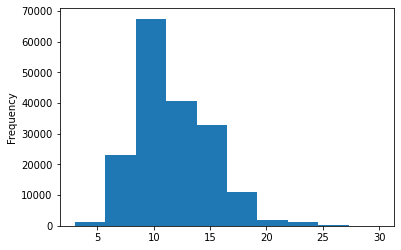

In [14]:
#let's check the length of diffrent lines
train_df.total_lines.plot.hist()

In [15]:
#get list of sentences 
train_sentences =train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()

In [16]:
len(train_sentences), len(val_sentences), len(test_sentences)



(180040, 30212, 30135)

In [17]:
#veiw the 10 lines of training sentence
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

#Make numeric labels

In [18]:
#one hot incode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)#tensorflow is incommpatible with Sparse datafile so we need set sparse to False
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))



#Label encode labels


In [19]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [20]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [21]:
#get Class names
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

#Model 0 Baseline 

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
#evaluate model0 on validation Data
model_0.score(X=val_sentences,y=val_labels_encoded)

0.7218323844829869

In [24]:
#Make prediction 
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
from helper_functions import calculate_results


In [26]:
#calculate baseline results
base_line_results=calculate_results(y_true=val_labels_encoded,y_pred=baseline_preds)
base_line_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

#text vectorization and prepare data



In [27]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np


In [28]:
#How long is each sentence on average ?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

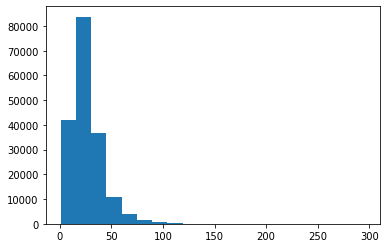

In [29]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [30]:
# How long of a setnence lenght covers 95% of examples?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [31]:
#Maximum sequence length 
max(sent_lens)

296

#Create text vectorizer layer

In [32]:
#How many words are in vocab?(based on Dataset Paper)
max_tokens=68000

In [33]:
#create vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer=TextVectorization(max_tokens=max_tokens,output_sequence_length=output_seq_len)

In [34]:
#Adapt text_vectorizer to train Sentences
text_vectorizer.adapt(train_sentences)

In [35]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
clinicaltrials.gov nct@ .

Length of text: 3

Vectorized text: [[275 176   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [36]:
#how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

#text Embedding layer

In [38]:
from tensorflow.keras import layers

In [39]:
#create token embedding 
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),output_dim=128,mask_zero=True,name="token_embeddig")
# different embedding sizes result in drastically differnt numbers of parameters to train

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 clinicaltrials.gov nct@ .

Sentence after vectorization (before embedding):
 [[275 176   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
 [[[ 0.00620544 -0.03627248 -0.02335378 ... -0.04019585  0.01907669
    0.01625875]
  [-0.03478593  0.03763774  0.04683122 ... -0.04174185 -0.00303574
    0.03945288]
  [-0.03962298 -0.03068894 -0.03490068 ... -0.04674944 -0.03648139
    0.03184484]
  ...
  [-0.03962298 -0.03068894 -0.03490068 ... -0.04674944 -0.03648139
    0.03184484]
  [-0.03962298 -0.03068894 -0.03490068 ... -0.04674944 -0.03648139
    0.03184484]
  [-0.03962298 -0.03068894 -0.03490068 ... -0.04674944 -0.03648139
    0.03184484]]]

Embedded sentence shape: (1, 55, 128)


#Creating datasets

In [41]:
#Turn our data into Tensorflow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))


In [42]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#Model1 :Cov1D with token embedding

In [44]:
#Create 1D conv model
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embeddings=token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)
#compile
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])


In [45]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embeddig (Embedding)  (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [46]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 17s 9ms/step - loss: 0.9111 - accuracy: 0.6367 - val_loss: 0.6851 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6574 - accuracy: 0.7560 - val_loss: 0.6296 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6169 - accuracy: 0.7757 - val_loss: 0.5963 - val_accuracy: 0.7819


In [47]:
#evaluate on whole dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5978 - accuracy: 0.7871


[0.5978217720985413, 0.7870713472366333]

In [48]:
#make predictions 
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs

array([[4.01574820e-01, 1.64955795e-01, 1.02913253e-01, 3.00785154e-01,
        2.97709573e-02],
       [4.43484455e-01, 2.72595942e-01, 1.00178365e-02, 2.67354369e-01,
        6.54729689e-03],
       [1.31149292e-01, 7.83772767e-03, 1.40717358e-03, 8.59554589e-01,
        5.12745792e-05],
       ...,
       [2.76249966e-06, 5.90553565e-04, 4.57729388e-04, 2.30307114e-06,
        9.98946726e-01],
       [5.09134121e-02, 4.64670390e-01, 9.43582878e-02, 6.80436417e-02,
        3.22014302e-01],
       [1.79942727e-01, 6.54006302e-01, 4.52199355e-02, 4.00445759e-02,
        8.07864442e-02]], dtype=float32)

In [49]:
# Convert pred probs to classes

model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
class_names


array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [51]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.70713623725672,
 'f1': 0.7847255090139503,
 'precision': 0.7837138997915044,
 'recall': 0.7870713623725671}

##model 2 : Feature extraction with pretrained token embeddings

In [52]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [53]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 the optimal anti-reflux procedure after heller cardiomyotomy for oesophageal achalasia remains unclear .
Setence after embedding:
[ 0.02671643 -0.06202696 -0.06323077 -0.00740644 -0.01963233 -0.09373431
 -0.06067842 -0.07433695  0.05459358  0.06293198  0.04394715  0.00105294
 -0.07399106 -0.00236625 -0.01576674  0.00501834  0.01349253  0.03120172
 -0.04658236  0.03579129 -0.07964295  0.06764099 -0.00075635 -0.05099599
 -0.06024321  0.02655845  0.07321969  0.08700735 -0.04162776  0.03581475]

Length of sentence embedding: 512


In [55]:
# tokenize text and create embedding of each sequence (512 long vector)
inputs=layers.Input(shape=[],dtype=tf.string)#
pretrained_embeddig=tf_hub_embedding_layer(inputs)## tokenize text and create embedding of each sequence (512 long vector)
x=layers.Dense(128,activation="relu")(pretrained_embeddig)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model2=tf.keras.Model(inputs,outputs,name="model2_feature_extarction")
#compile the model
model2.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [56]:
model2.summary()

Model: "model2_feature_extarction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [58]:
#fit model 2 
history_2=model2.fit(train_dataset,epochs=3,steps_per_epoch=(0.1*len(train_dataset)),validation_data=valid_dataset,validation_steps=(0.1*(len(valid_dataset))))

Epoch 1/3
562/562 [==============================] - 18s 26ms/step - loss: 0.9140 - accuracy: 0.6487 - val_loss: 0.8042 - val_accuracy: 0.6859
Epoch 2/3
562/562 [==============================] - 13s 23ms/step - loss: 0.7702 - accuracy: 0.7021 - val_loss: 0.7599 - val_accuracy: 0.7079
Epoch 3/3
562/562 [==============================] - 13s 23ms/step - loss: 0.7514 - accuracy: 0.7119 - val_loss: 0.7406 - val_accuracy: 0.7158


In [59]:
model2.evaluate(valid_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.7403 - accuracy: 0.7145


[0.7403357625007629, 0.7145174145698547]

In [61]:
#Make predictions
model2_pred_probs=model2.predict(valid_dataset)
model2_pred_probs

array([[4.4624969e-01, 3.2793990e-01, 2.6377046e-03, 2.1544123e-01,
        7.7314251e-03],
       [3.4807792e-01, 4.7732669e-01, 3.6945110e-03, 1.6812325e-01,
        2.7776260e-03],
       [2.3231536e-01, 1.4390579e-01, 1.9005433e-02, 5.7010621e-01,
        3.4667227e-02],
       ...,
       [1.6407178e-03, 6.6294186e-03, 5.5270031e-02, 9.1437745e-04,
        9.3554550e-01],
       [4.2601060e-03, 4.5233801e-02, 1.8103366e-01, 1.5285466e-03,
        7.6794392e-01],
       [1.8406266e-01, 2.3630793e-01, 5.1957762e-01, 6.9633364e-03,
        5.3088505e-02]], dtype=float32)

In [63]:
#Convert the prediction probabilities 
model2_preds=tf.argmax(model2_pred_probs,axis=1)
model2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [65]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model2_preds)
model_2_results

{'accuracy': 71.45174103005428,
 'f1': 0.7118996804521432,
 'precision': 0.7145638860225308,
 'recall': 0.7145174103005428}